# Temporal Aggregation (Tourism)

> Temporal Hierarchical Forecasting on Australian Tourism Data

In many applications, a set of time series is hierarchically organized. Examples include the presence of geographic levels, products, or categories that define different types of aggregations. In such scenarios, forecasters are often required to provide predictions for all disaggregate and aggregate series. A natural desire is for those predictions to be **"coherent"**, that is, for the bottom series to add up precisely to the forecasts of the aggregated series.

In this notebook we present an example on how to use `HierarchicalForecast` to produce coherent forecasts between  temporal levels. We will use the classic Australian Domestic Tourism (`Tourism`) dataset, which contains monthly time series of the number of visitors to each state of Australia.

We will first load the `Tourism` data and produce base forecasts using an `AutoETS` model from `StatsForecast`. Then, we reconciliate the forecasts with several reconciliation algorithms from `HierarchicalForecast` according to a temporal hierarchy.

You can run these experiments using CPU or GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/hierarchicalforecast/blob/main/nbs/examples/AustralianDomesticTourismTemporal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install hierarchicalforecast statsforecast

## 1. Load and Process Data

In this example we will use the [Tourism](https://otexts.com/fpp3/tourism.html) dataset from the [Forecasting: Principles and Practice](https://otexts.com/fpp3/) book.

The dataset only contains the time series at the lowest level, so we need to create the time series for all hierarchies.

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
Y_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/tourism.csv')
Y_df = Y_df.rename({'Trips': 'y', 'Quarter': 'ds'}, axis=1)
Y_df.insert(0, 'Country', 'Australia')
Y_df = Y_df[['Country', 'Region', 'State', 'Purpose', 'ds', 'y']]
Y_df['ds'] = Y_df['ds'].str.replace(r'(\d+) (Q\d)', r'\1-\2', regex=True)
Y_df['ds'] = pd.PeriodIndex(Y_df["ds"], freq='Q').to_timestamp()
Y_df.head()

Country    Region            State   Purpose         ds           y
0  Australia  Adelaide  South Australia  Business 1998-01-01  135.077690
1  Australia  Adelaide  South Australia  Business 1998-04-01  109.987316
2  Australia  Adelaide  South Australia  Business 1998-07-01  166.034687
3  Australia  Adelaide  South Australia  Business 1998-10-01  127.160464
4  Australia  Adelaide  South Australia  Business 1999-01-01  137.448533

## 2. Temporal reconciliation

First, we add a `unique_id` to the data.

In [ ]:
Y_df["unique_id"] = Y_df["Country"] + "/" + Y_df["State"] + "/" + Y_df["Region"] + "/" + Y_df["Purpose"]

### 2a. Split Train/Test sets

We use the final two years (8 quarters) as test set. Consequently, our forecast horizon=8.

In [ ]:
horizon = 8

In [ ]:
Y_test_df = Y_df.groupby("unique_id", as_index=False).tail(horizon)
Y_train_df = Y_df.drop(Y_test_df.index)

### 2a. Aggregating the dataset according to temporal hierarchy

We first define the temporal aggregation spec. You can use string aliases of timestamp attributes to compute temporal aggregations. For Pandas, see an overview of allowable attributes [here](https://pandas.pydata.org/docs/reference/api/pandas.Timestamp.html). 

In this example, we choose a temporal aggregation of `["year"]` and the bottom level `["year", "ds"]`. The bottom level timesteps have a quarterly frequency.

In [ ]:
spec_temporal = {"year": 4, "quarter": 1}

We next compute the temporally aggregated train- and test sets using the `aggregate_temporal` function. Note that we have different aggregation matrices `S` for the train- and test set, as the test set contains temporal hierarchies that are not included in the train set.

In [ ]:
from hierarchicalforecast.utils import aggregate_temporal

In [ ]:
Y_train_df_te, S_train_df_te, tags_te_train = aggregate_temporal(df=Y_train_df, spec=spec_temporal)
Y_test_df_te, S_test_df_te, tags_te_test = aggregate_temporal(df=Y_test_df,  spec=spec_temporal)


In [ ]:
tags_te_train

{'year': array(['year-1', 'year-2', 'year-3', 'year-4', 'year-5', 'year-6',
        'year-7', 'year-8', 'year-9', 'year-10', 'year-11', 'year-12',
        'year-13', 'year-14', 'year-15', 'year-16', 'year-17', 'year-18'],
       dtype=object),
 'year/quarter': array(['year-1/quarter-1', 'year-1/quarter-2', 'year-1/quarter-3',
        'year-1/quarter-4', 'year-2/quarter-5', 'year-2/quarter-6',
        'year-2/quarter-7', 'year-2/quarter-8', 'year-3/quarter-9',
        'year-3/quarter-10', 'year-3/quarter-11', 'year-3/quarter-12',
        'year-4/quarter-13', 'year-4/quarter-14', 'year-4/quarter-15',
        'year-4/quarter-16', 'year-5/quarter-17', 'year-5/quarter-18',
        'year-5/quarter-19', 'year-5/quarter-20', 'year-6/quarter-21',
        'year-6/quarter-22', 'year-6/quarter-23', 'year-6/quarter-24',
        'year-7/quarter-25', 'year-7/quarter-26', 'year-7/quarter-27',
        'year-7/quarter-28', 'year-8/quarter-29', 'year-8/quarter-30',
        'year-8/quarter-31', 'year-8/qu

Our aggregation matrices aggregate the lowest temporal granularity (quarters) up to years.

In [ ]:
S_train_df_te.iloc[:5, :5]

temporal_id  year-1/quarter-1  year-1/quarter-2  year-1/quarter-3  \
0      year-1               1.0               1.0               1.0   
1      year-2               0.0               0.0               0.0   
2      year-3               0.0               0.0               0.0   
3      year-4               0.0               0.0               0.0   
4      year-5               0.0               0.0               0.0   

   year-1/quarter-4  
0               1.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0

In [ ]:
S_test_df_te.iloc[:5, :5]

temporal_id  year-1/quarter-1  year-1/quarter-2  year-1/quarter-3  \
0            year-1               1.0               1.0               1.0   
1            year-2               0.0               0.0               0.0   
2  year-1/quarter-1               1.0               0.0               0.0   
3  year-1/quarter-2               0.0               1.0               0.0   
4  year-1/quarter-3               0.0               0.0               1.0   

   year-1/quarter-4  
0               1.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0

If you don't have a test set available, as is usually the case when you're making forecasts, it is necessary to create a future dataframe that holds the correct bottom-level unique_ids and timestamps so that they can be temporally aggregated. We can use the `make_future_dataframe` helper function for that.

In [ ]:
from hierarchicalforecast.utils import make_future_dataframe

In [ ]:
Y_test_df_te_new = make_future_dataframe(Y_train_df, freq="QS", h=horizon)

`Y_test_df_te_new` can be then used in `aggregate_temporal` to construct the temporally aggregated structures:

In [ ]:
Y_df_test_new, S_df_te_test_new, tags_te_test_new = aggregate_temporal(df=Y_test_df_te_new,  spec=spec_temporal)

And we can verify that we have the same temporally aggregated test set, except that `Y_df_te_test_new` doesn't contain the ground truth values `y`.

In [ ]:
S_df_te_test_new

temporal_id  year-1/quarter-1  year-1/quarter-2  year-1/quarter-3  \
0            year-1               1.0               1.0               1.0   
1            year-2               0.0               0.0               0.0   
2  year-1/quarter-1               1.0               0.0               0.0   
3  year-1/quarter-2               0.0               1.0               0.0   
4  year-1/quarter-3               0.0               0.0               1.0   
5  year-1/quarter-4               0.0               0.0               0.0   
6  year-2/quarter-5               0.0               0.0               0.0   
7  year-2/quarter-6               0.0               0.0               0.0   
8  year-2/quarter-7               0.0               0.0               0.0   
9  year-2/quarter-8               0.0               0.0               0.0   

   year-1/quarter-4  year-2/quarter-5  year-2/quarter-6  year-2/quarter-7  \
0               1.0               0.0               0.0               0.0   
1               0.0               1.0               1.0               1.0   
2               0.0               0.0               0.0               0.0   
3               0.0               0.0               0.0               0.0   
4               0.0               0.0               0.0               0.0   
5               1.0               0.0               0.0               0.0   
6               0.0               1.0               0.0               0.0   
7               0.0               0.0               1.0               0.0   
8               0.0               0.0               0.0               1.0   
9               0.0               0.0               0.0               0.0   

   year-2/quarter-8  
0               0.0  
1               1.0  
2               0.0  
3               0.0  
4               0.0  
5               0.0  
6               0.0  
7               0.0  
8               0.0  
9               1.0

In [ ]:
Y_test_df_te

temporal_id                                          unique_id  \
0               year-1                    Australia/ACT/Canberra/Business   
1               year-2                    Australia/ACT/Canberra/Business   
2               year-1                     Australia/ACT/Canberra/Holiday   
3               year-2                     Australia/ACT/Canberra/Holiday   
4               year-1                       Australia/ACT/Canberra/Other   
...                ...                                                ...   
3035  year-1/quarter-4  Australia/Western Australia/Experience Perth/V...   
3036  year-2/quarter-5  Australia/Western Australia/Experience Perth/V...   
3037  year-2/quarter-6  Australia/Western Australia/Experience Perth/V...   
3038  year-2/quarter-7  Australia/Western Australia/Experience Perth/V...   
3039  year-2/quarter-8  Australia/Western Australia/Experience Perth/V...   

             ds           y  
0    2016-10-01  754.139245  
1    2017-10-01  809.950839  
2    2016-10-01  735.365896  
3    2017-10-01  834.717900  
4    2016-10-01  175.239916  
...         ...         ...  
3035 2016-10-01  439.699451  
3036 2017-01-01  356.867038  
3037 2017-04-01  302.296119  
3038 2017-07-01  373.442070  
3039 2017-10-01  455.316702  

[3040 rows x 4 columns]

In [ ]:
Y_df_test_new

temporal_id                                          unique_id  \
0               year-1                    Australia/ACT/Canberra/Business   
1               year-2                    Australia/ACT/Canberra/Business   
2               year-1                     Australia/ACT/Canberra/Holiday   
3               year-2                     Australia/ACT/Canberra/Holiday   
4               year-1                       Australia/ACT/Canberra/Other   
...                ...                                                ...   
3035  year-1/quarter-4  Australia/Western Australia/Experience Perth/V...   
3036  year-2/quarter-5  Australia/Western Australia/Experience Perth/V...   
3037  year-2/quarter-6  Australia/Western Australia/Experience Perth/V...   
3038  year-2/quarter-7  Australia/Western Australia/Experience Perth/V...   
3039  year-2/quarter-8  Australia/Western Australia/Experience Perth/V...   

             ds  
0    2016-10-01  
1    2017-10-01  
2    2016-10-01  
3    2017-10-01  
4    2016-10-01  
...         ...  
3035 2016-10-01  
3036 2017-01-01  
3037 2017-04-01  
3038 2017-07-01  
3039 2017-10-01  

[3040 rows x 3 columns]

### 3b. Computing base forecasts

Now, we need to compute base forecasts for each temporal aggregation. The following cell computes the **base forecasts** for each temporal aggregation in `Y_train_df_te` using the `AutoETS` model. Observe that `Y_hat_df_te` contains the forecasts but they are not coherent.

Note also that both frequency and horizon are different for each temporal aggregation. In this example, the lowest level has a quarterly frequency, and a horizon of `8` (constituting `2` years). The `year` aggregation thus has a yearly frequency with a horizon of `2`.

It is of course possible to choose a different model for each level in the temporal aggregation - you can be as creative as you like!

In [ ]:
from statsforecast.models import AutoETS
from statsforecast.core import StatsForecast

In [ ]:
Y_test_df_te

temporal_id                                          unique_id  \
0               year-1                    Australia/ACT/Canberra/Business   
1               year-2                    Australia/ACT/Canberra/Business   
2               year-1                     Australia/ACT/Canberra/Holiday   
3               year-2                     Australia/ACT/Canberra/Holiday   
4               year-1                       Australia/ACT/Canberra/Other   
...                ...                                                ...   
3035  year-1/quarter-4  Australia/Western Australia/Experience Perth/V...   
3036  year-2/quarter-5  Australia/Western Australia/Experience Perth/V...   
3037  year-2/quarter-6  Australia/Western Australia/Experience Perth/V...   
3038  year-2/quarter-7  Australia/Western Australia/Experience Perth/V...   
3039  year-2/quarter-8  Australia/Western Australia/Experience Perth/V...   

             ds           y  
0    2016-10-01  754.139245  
1    2017-10-01  809.950839  
2    2016-10-01  735.365896  
3    2017-10-01  834.717900  
4    2016-10-01  175.239916  
...         ...         ...  
3035 2016-10-01  439.699451  
3036 2017-01-01  356.867038  
3037 2017-04-01  302.296119  
3038 2017-07-01  373.442070  
3039 2017-10-01  455.316702  

[3040 rows x 4 columns]

In [ ]:
Y_hat_dfs_te = []
id_cols = ["unique_id", "temporal_id", "ds", "y"]
# We will train a model for each temporal level
for level, temporal_ids_train in tags_te_train.items():
    # Filter the data for the level
    Y_level_train = Y_train_df_te.query("temporal_id in @temporal_ids_train")
    temporal_ids_test = tags_te_test[level]
    Y_level_test = Y_test_df_te.query("temporal_id in @temporal_ids_test")
    # For each temporal level we have a different frequency and forecast horizon
    freq_level = pd.infer_freq(Y_level_train["ds"].unique())
    horizon_level = Y_level_test["ds"].nunique()
    # Train a model and create forecasts
    fcst = StatsForecast(models=[AutoETS(model='ZZZ')], freq=freq_level, n_jobs=-1)
    Y_hat_df_te_level = fcst.forecast(df=Y_level_train[["ds", "unique_id", "y"]], h=horizon_level, level=[80, 90])
    # Add the test set to the forecast
    Y_hat_df_te_level = Y_hat_df_te_level.merge(Y_level_test, on=["ds", "unique_id"], how="left")
    # Put cols in the right order (for readability)
    Y_hat_cols = id_cols + [col for col in Y_hat_df_te_level.columns if col not in id_cols]
    Y_hat_df_te_level = Y_hat_df_te_level[Y_hat_cols]
    # Append the forecast to the list
    Y_hat_dfs_te.append(Y_hat_df_te_level)

Y_hat_df_te = pd.concat(Y_hat_dfs_te, ignore_index=True)


In [ ]:
Y_level_test

temporal_id                                          unique_id  \
608   year-1/quarter-1                    Australia/ACT/Canberra/Business   
609   year-1/quarter-2                    Australia/ACT/Canberra/Business   
610   year-1/quarter-3                    Australia/ACT/Canberra/Business   
611   year-1/quarter-4                    Australia/ACT/Canberra/Business   
612   year-2/quarter-5                    Australia/ACT/Canberra/Business   
...                ...                                                ...   
3035  year-1/quarter-4  Australia/Western Australia/Experience Perth/V...   
3036  year-2/quarter-5  Australia/Western Australia/Experience Perth/V...   
3037  year-2/quarter-6  Australia/Western Australia/Experience Perth/V...   
3038  year-2/quarter-7  Australia/Western Australia/Experience Perth/V...   
3039  year-2/quarter-8  Australia/Western Australia/Experience Perth/V...   

             ds           y  
608  2016-01-01  152.599480  
609  2016-04-01  195.719394  
610  2016-07-01  219.421298  
611  2016-10-01  186.399072  
612  2017-01-01  169.318611  
...         ...         ...  
3035 2016-10-01  439.699451  
3036 2017-01-01  356.867038  
3037 2017-04-01  302.296119  
3038 2017-07-01  373.442070  
3039 2017-10-01  455.316702  

[2432 rows x 4 columns]

### 3c. Reconcile forecasts

We can use the `HierarchicalReconciliation` class to reconcile the forecasts. In this example we use `BottomUp` and `MinTrace`. Note that we have to set `temporal=True` in the `reconcile` function.

Note that temporal reconcilation currently isn't supported for insample reconciliation methods, such as `MinTrace(method='mint_shrink')`.

In [ ]:
from hierarchicalforecast.methods import BottomUp, MinTrace
from hierarchicalforecast.core import HierarchicalReconciliation

In [ ]:
reconcilers = [
    BottomUp(),
    MinTrace(method="ols"),
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df_te = hrec.reconcile(Y_hat_df=Y_hat_df_te, S=S_test_df_te, tags=tags_te_test, temporal=True, level=[80, 90])

In [ ]:
S_train_df_te

temporal_id  year-1/quarter-1  year-1/quarter-2  year-1/quarter-3  \
0               year-1               1.0               1.0               1.0   
1               year-2               0.0               0.0               0.0   
2               year-3               0.0               0.0               0.0   
3               year-4               0.0               0.0               0.0   
4               year-5               0.0               0.0               0.0   
..                 ...               ...               ...               ...   
85  year-17/quarter-68               0.0               0.0               0.0   
86  year-18/quarter-69               0.0               0.0               0.0   
87  year-18/quarter-70               0.0               0.0               0.0   
88  year-18/quarter-71               0.0               0.0               0.0   
89  year-18/quarter-72               0.0               0.0               0.0   

    year-1/quarter-4  year-2/quarter-5  year-2/quarter-6  year-2/quarter-7  \
0                1.0               0.0               0.0               0.0   
1                0.0               1.0               1.0               1.0   
2                0.0               0.0               0.0               0.0   
3                0.0               0.0               0.0               0.0   
4                0.0               0.0               0.0               0.0   
..               ...               ...               ...               ...   
85               0.0               0.0               0.0               0.0   
86               0.0               0.0               0.0               0.0   
87               0.0               0.0               0.0               0.0   
88               0.0               0.0               0.0               0.0   
89               0.0               0.0               0.0               0.0   

    year-2/quarter-8  year-3/quarter-9  ...  year-16/quarter-63  \
0                0.0               0.0  ...                 0.0   
1                1.0               0.0  ...                 0.0   
2                0.0               1.0  ...                 0.0   
3                0.0               0.0  ...                 0.0   
4                0.0               0.0  ...                 0.0   
..               ...               ...  ...                 ...   
85               0.0               0.0  ...                 0.0   
86               0.0               0.0  ...                 0.0   
87               0.0               0.0  ...                 0.0   
88               0.0               0.0  ...                 0.0   
89               0.0               0.0  ...                 0.0   

    year-16/quarter-64  year-17/quarter-65  year-17/quarter-66  \
0                  0.0                 0.0                 0.0   
1                  0.0                 0.0                 0.0   
2                  0.0                 0.0                 0.0   
3                  0.0                 0.0                 0.0   
4                  0.0                 0.0                 0.0   
..                 ...                 ...                 ...   
85                 0.0                 0.0                 0.0   
86                 0.0                 0.0                 0.0   
87                 0.0                 0.0                 0.0   
88                 0.0                 0.0                 0.0   
89                 0.0                 0.0                 0.0   

    year-17/quarter-67  year-17/quarter-68  year-18/quarter-69  \
0                  0.0                 0.0                 0.0   
1                  0.0                 0.0                 0.0   
2                  0.0                 0.0                 0.0   
3                  0.0                 0.0                 0.0   
4                  0.0                 0.0                 0.0   
..                 ...                 ...                 ...   
85                 0.0                 1.0           

In [ ]:
Y_rec_df_te

unique_id       temporal_id  \
0                       Australia/ACT/Canberra/Business            year-1   
1                        Australia/ACT/Canberra/Holiday            year-1   
2                          Australia/ACT/Canberra/Other            year-1   
3                       Australia/ACT/Canberra/Visiting            year-1   
4     Australia/New South Wales/Blue Mountains/Business            year-1   
...                                                 ...               ...   
3035  Australia/Western Australia/Australia's South ...  year-2/quarter-8   
3036  Australia/Western Australia/Experience Perth/B...  year-2/quarter-8   
3037  Australia/Western Australia/Experience Perth/H...  year-2/quarter-8   
3038  Australia/Western Australia/Experience Perth/O...  year-2/quarter-8   
3039  Australia/Western Australia/Experience Perth/V...  year-2/quarter-8   

             ds           y     AutoETS  AutoETS-lo-90  AutoETS-lo-80  \
0    2016-10-01  754.139245  616.497987     474.588329     505.932195   
1    2016-10-01  735.365896  584.287176     427.669022     462.261583   
2    2016-10-01  175.239916  112.787569      65.076862      75.614820   
3    2016-10-01  792.656310  713.720077     608.502896     631.742422   
4    2016-10-01   73.981175   78.095125      32.930588      42.906168   
...         ...         ...         ...            ...            ...   
3035 2017-10-01  209.846009  220.751828     112.239083     136.206507   
3036 2017-10-01  270.986641  202.302327     110.811031     131.018894   
3037 2017-10-01  288.758614  278.976867     194.106219     212.851766   
3038 2017-10-01   87.494916   93.485207      40.907227      52.520229   
3039 2017-10-01  455.316702  406.020079     235.722220     273.336244   

      AutoETS-hi-80  AutoETS-hi-90  AutoETS/BottomUp  AutoETS/BottomUp-lo-90  \
0        727.063780     758.407646        578.768957              451.643145   
1        706.312770     740.905330        584.386505              454.162576   
2        149.960319     160.498277        112.817793               73.130681   
3        795.697733     818.937259        713.456472              616.125151   
4        113.284082     123.259662         78.068305               38.085984   
...             ...            ...               ...                     ...   
3035     305.297149     329.264572        220.751828              112.239083   
3036     273.585760     293.793623        202.302327              110.811031   
3037     345.101969     363.847516        278.976867              194.106219   
3038     134.450185     146.063187         93.485207               40.907227   
3039     538.703915     576.317939        406.020079              235.722220   

      AutoETS/BottomUp-lo-80  AutoETS/BottomUp-hi-80  AutoETS/BottomUp-hi-90  \
0                 479.721674              677.816240              705.894769   
1                 482.925392              685.847619              714.610435   
2                  81.896452              143.739133              152.504904   
3                 637.622912              789.290031              810.787792   
4                  46.916958              109.219652              118.050626   
...                      ...                     ...                     ...   
3035              136.206507              305.297149              329.264572   
3036              131.018894              273.585760              293.793623   
3037              212.851766              345.101969              363.847516   
3038               52.520229              134.450185              146.063187   
3039              273.336244              538.703915              576.317939   

      AutoETS/MinTrace_method-ols  AutoETS/MinTrace_method-ols-lo-90  \
0                      608.952181                         492.612233   
1                      584.307042                         456.334200   
2                      112.793614                          73.808462   
3                      713.667356 

## 4. Evaluation 

The `HierarchicalForecast` package includes the `evaluate` function to evaluate the different hierarchies.

We evaluate the temporally aggregated forecasts _across all temporal aggregations_. Note that we set the `tags_te` attribute in the `evaluate` function, to enable the `evaluate` function to evaluate in the temporal dimension, rather than the cross-sectional dimension.

In [ ]:
from hierarchicalforecast.evaluation import evaluate
from utilsforecast.losses import mae, scaled_crps

In [ ]:
eval_tags = {}
eval_tags['Year'] = tags_te_test['year']
eval_tags['Quarter'] = tags_te_test['year/quarter']

evaluation = evaluate(df = Y_rec_df_te.drop(columns = 'unique_id'),
                      tags = eval_tags,
                      metrics = [mae, scaled_crps],
                      level = [80, 90],
                      id_col='temporal_id')

evaluation.columns = ['level', 'metric', 'Base', 'BottomUp', 'MinTrace(ols)']
numeric_cols = evaluation.select_dtypes(include="number").columns
evaluation[numeric_cols] = evaluation[numeric_cols].map('{:.2f}'.format).astype(np.float64)

In [ ]:
evaluation

level       metric   Base  BottomUp  MinTrace(ols)
0     Year          mae  46.98     50.78          46.90
1     Year  scaled_crps   0.06      0.06           0.06
2  Quarter          mae  19.42     19.42          18.74
3  Quarter  scaled_crps   0.09      0.09           0.08
4  Overall          mae  24.93     25.69          24.37
5  Overall  scaled_crps   0.08      0.08           0.08

`MinTrace(ols)` is the best overall point method, scoring the lowest `mae` on both the `Quarter` aggregated forecasts as well as the `Year` aggregated forecasts. However, the `Base` method is better on the probabilistic measures, where it scores the lowest `scaled_crps`, indicating the levels predicted with the `Base` method are better in this example.

## Appendix: plotting the S matrix


In [ ]:
from hierarchicalforecast.utils import HierarchicalPlot

We plot our summing matrix for the test set. It's fairly straightforward: there are two years in the test set, consisting of 4 quarters each. 
* The first row of the `S` matrix shows how the aggregation `2016` can be obtained by summing the 4 quarters in 2016.
* The second row of the `S` matrix shows how the aggregation `2017` can be obtained by summing the 4 quarters in 2017. 
* The final rows are the identity matrix for each quarter, denoting the bottom temporal level (each quarter).


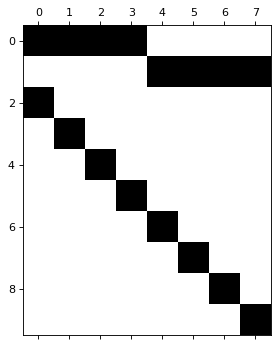

In [ ]:
hplot = HierarchicalPlot(S=S_test_df_te, tags=tags_te_test, S_id_col="temporal_id")
hplot.plot_summing_matrix()